<a href="https://colab.research.google.com/github/Ramkkkkkk/ramkumar/blob/master/Another_copy_of_Eye_diseases_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!python --version

Python 3.10.12


In [5]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = (
    'eye-diseases-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2440665%2F4130910%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240726%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240726T075028Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dbd9c8a191b69699611ebfa42be57ea06bc5d972319146f0dc12c2075a0fdf7a377d992149667652033676666d7f85ad09cf937e7088d8d9258744919fa71f6101e0bf62f22e979e54f0e95cc1f0aff85a4197577031051b87e6d80e247084b67c13fb74d3a8d3d0b9ebc566fa6e2afa6cdfd91f9a840c57d5d0a22e4aa81b512fb72a4da7a38532e3254923b10a675f5f52653e9d0a1c892fda972744d8a4eb17983706af7ca7571cd586a3ebc4b49e60052c7149cd01b0a118dda1de58f1f8463216270f997168a35c99de34c5f6e102d103168507d3dd9338c70612117f752211b519342eead5cb6b95097c5aa7d264a6c827d3247ef0f21b2c379fbb5a6ec'
)

KAGGLE_INPUT_PATH = '/kaggle/input'
KAGGLE_WORKING_PATH = '/kaggle/working'

# Clean up existing directories and create new ones
def setup_directories():
    if os.path.ismount(KAGGLE_INPUT_PATH):
        os.system(f'umount {KAGGLE_INPUT_PATH} 2> /dev/null')
    shutil.rmtree(KAGGLE_INPUT_PATH, ignore_errors=True)
    os.makedirs(KAGGLE_INPUT_PATH, exist_ok=True)
    os.makedirs(KAGGLE_WORKING_PATH, exist_ok=True)

    try:
        os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'))
    except FileExistsError:
        pass
    try:
        os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'))
    except FileExistsError:
        pass

setup_directories()

# Download and extract datasets
def download_and_extract():
    for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
        directory, download_url_encoded = data_source_mapping.split(':')
        download_url = unquote(download_url_encoded)
        filename = urlparse(download_url).path.split('/')[-1]
        destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)

        try:
            with urlopen(download_url) as fileres, NamedTemporaryFile(delete=False) as tfile:
                total_length = fileres.headers.get('content-length')
                if total_length:
                    total_length = int(total_length)
                print(f'Downloading {directory}, {total_length} bytes compressed')

                dl = 0
                while (chunk := fileres.read(CHUNK_SIZE)):
                    tfile.write(chunk)
                    dl += len(chunk)
                    done = int(50 * dl / total_length) if total_length else 50
                    sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                    sys.stdout.flush()

                tfile.close()  # Close the file before extracting

                if filename.endswith('.zip'):
                    with ZipFile(tfile.name, 'r') as zfile:
                        zfile.extractall(destination_path)
                elif filename.endswith('.tar') or filename.endswith('.tar.gz') or filename.endswith('.tgz'):
                    with tarfile.open(tfile.name, 'r:*') as tarfile:
                        tarfile.extractall(destination_path)
                else:
                    print(f'Unsupported file format: {filename}')

                print(f'\nDownloaded and uncompressed: {directory}')
        except HTTPError as e:
            print(f'Failed to load (likely expired) {download_url} to path {destination_path}: {e}')
        except OSError as e:
            print(f'Failed to load {download_url} to path {destination_path}: {e}')

download_and_extract()

print('Data source import complete.')

[==================================================] 771355331 bytes downloaded
Downloaded and uncompressed: eye-diseases-classification
Data source import complete.


## Eye diseases

Diabetes is a condition that carries an increased risk of developing eye complications. Diabetic eye disease includes complications such as diabetic retinopathy, cataracts and glaucoma.

Diabetes is the leading cause of blindness in working-age adults. People with type 1 and type 2 diabetes are at risk. It’s possible to be unaware that you have severe diabetic eye disease and suddenly go blind. Fortunately, most cases of blindness can be prevented with regular eye examinations and proper care.

- The dataset consists of Normal, Diabetic Retinopathy, Cataract and Glaucoma retinal images where each class have approximately 1000 images. These images are collected from various sorces like IDRiD, Oculur recognition, HRF etc.

- Diabetic retinopathy: The persistently high blood sugar levels that occur with diabetes can damage the retina’s small blood vessels (capillaries), which deliver oxygen and nutrients. Diabetic retinopathy affects up to a third of people with diabetes over the age of 502.

- Cataracts: A cataract is a clouding of the lens in the eye. Left untreated, cataracts can eventually lead to blindness. People with diabetes are more likely to develop cataracts at an earlier age and suffer visual impairment faster than those without the condition.1,3

- Glaucoma: This is a group of conditions that can damage the optic nerve. The optic nerve transmits signals from the retina to the brain for processing. Glaucoma is often (but not always) a result of increased pressure inside the eye. The risk of glaucoma in people with diabetes is significantly higher than that of the general population.1,4 The two main types are open-angle glaucoma (also called ‘the sneak thief of sight’) and angle-closure glaucoma (this comes on suddenly and is a medical emergency).

## Import Libraries

# New Section

In [7]:
# import system libs
import os
import time
# import data handling tools
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, GlobalAveragePooling2D
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

## Class for Loading and Splitting Datasets

In [8]:
class EyeDiseaseDataset:
    def __init__(self, dataDir):
        self.data_dir = dataDir

    def dataPaths(self):
        filepaths = []
        labels = []
        folds = os.listdir(self.data_dir)
        for fold in folds:
            foldPath = os.path.join(self.data_dir, fold)
            filelist = os.listdir(foldPath)
            for file in filelist:
                fpath = os.path.join(foldPath, file)
                filepaths.append(fpath)
                labels.append(fold)
        return filepaths, labels

    def dataFrame(self, files, labels):

        Fseries = pd.Series(files, name='filepaths')
        Lseries = pd.Series(labels, name='labels')
        return pd.concat([Fseries, Lseries], axis=1)

    def split_(self):
        files, labels = self.dataPaths()
        df = self.dataFrame(files, labels)
        strat = df['labels']
        trainData, dummyData = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=strat)
        strat = dummyData['labels']
        validData, testData = train_test_split(dummyData, train_size=0.5, shuffle=True, random_state=42, stratify=strat)
        return trainData, validData, testData

In [9]:
dataDir='/kaggle/input/eye-diseases-classification/dataset'

In [10]:
dataSplit = EyeDiseaseDataset(dataDir)
train_data, valid_data, test_data = dataSplit.split_()

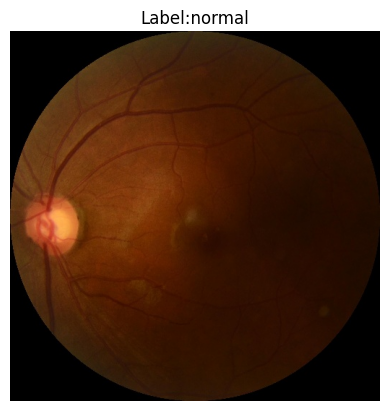

In [11]:
def display_random_image(df):
    random_row = df.sample(1).iloc[0]
    filepath = random_row['filepaths']
    label = random_row['labels']

    img = Image.open(filepath)
    plt.imshow(img)
    plt.title(f'Label:{label}')
    plt.axis('off')
    plt.show()

display_random_image(train_data)

## Function for Data Augmentation

In [12]:
def augment_data( train_df, valid_df, test_df, batch_size=16):

    img_size = (256,256)
    channels = 3
    color = 'rgb'


    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
              rotation_range=30,
              horizontal_flip=True,
              vertical_flip=True,
              brightness_range=[0.5, 1.5])

    valid_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

    train_generator = train_datagen.flow_from_dataframe(
              train_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )

    print("Shape of augmented training images:", train_generator.image_shape)

    valid_generator = valid_test_datagen.flow_from_dataframe(
              valid_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )

    print("Shape of validation images:", valid_generator.image_shape)

    test_generator = valid_test_datagen.flow_from_dataframe(
              test_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=False,
              class_mode='categorical'
          )

    print("Shape of test images:", test_generator.image_shape)

    return train_generator, valid_generator, test_generator

In [13]:
train_augmented, valid_augmented, test_augmented = augment_data(train_data, valid_data, test_data)

Found 3373 validated image filenames belonging to 4 classes.
Shape of augmented training images: (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of validation images: (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of test images: (256, 256, 3)


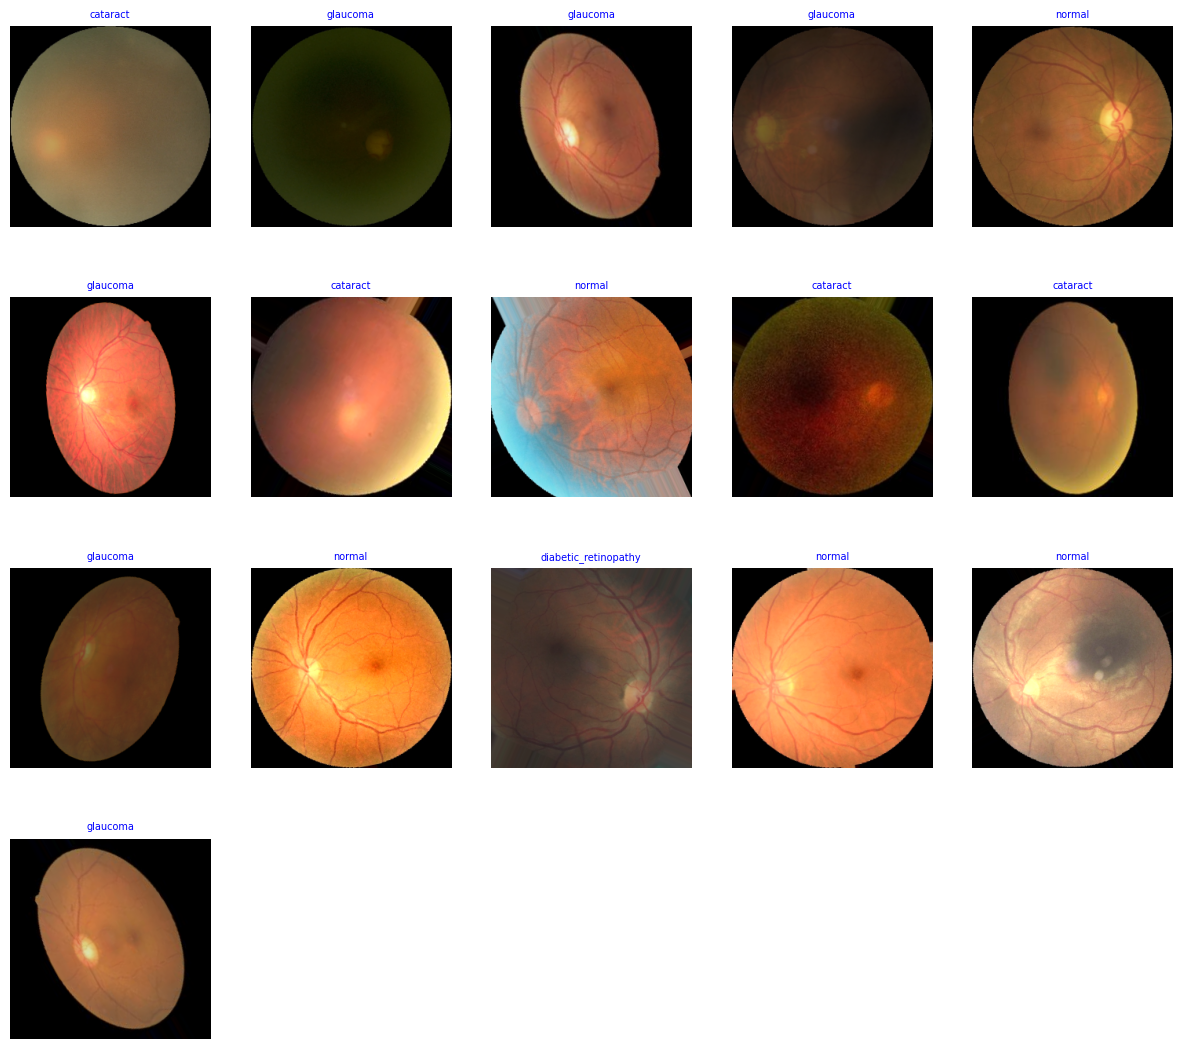

In [14]:
def show_images(gen):

    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator
    length = len(labels)
    sample = min(length, 20)
    plt.figure(figsize= (15, 17))
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 7 )
        plt.axis('off')
    plt.show()
show_images(train_augmented)

## Download and compile the model

In [15]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import regularizers

classes = len(list(train_augmented.class_indices.keys()))

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu' , kernel_regularizer = regularizers.l2(0.01))(x)

predictions = Dense(classes, activation='softmax', kernel_regularizer = regularizers.l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

43941136/43941136 [==============================] - 0s 0us/step


In [16]:
history = model.fit(
    train_augmented,
    epochs=15,
    validation_data=valid_augmented,


    );

Epoch 1/15
211/211 [==============================] - 103s 404ms/step - loss: 2.4147 - accuracy: 0.7427 - val_loss: 0.9951 - val_accuracy: 0.7488
Epoch 2/15
211/211 [==============================] - 80s 378ms/step - loss: 0.8242 - accuracy: 0.7788 - val_loss: 0.8074 - val_accuracy: 0.7678
Epoch 3/15
211/211 [==============================] - 79s 375ms/step - loss: 0.7042 - accuracy: 0.7954 - val_loss: 0.8376 - val_accuracy: 0.7393
Epoch 4/15
211/211 [==============================] - 80s 379ms/step - loss: 0.7106 - accuracy: 0.7768 - val_loss: 0.7601 - val_accuracy: 0.7654
Epoch 5/15
211/211 [==============================] - 79s 375ms/step - loss: 0.6885 - accuracy: 0.7928 - val_loss: 0.6672 - val_accuracy: 0.8057
Epoch 6/15
211/211 [==============================] - 79s 376ms/step - loss: 0.6749 - accuracy: 0.7948 - val_loss: 0.7444 - val_accuracy: 0.7701
Epoch 7/15
211/211 [==============================] - 81s 384ms/step - loss: 0.6521 - accuracy: 0.8020 - val_loss: 0.8039 - val_a

## Fit the model

## Plot the Accuracy and Loss

Training Accuracy: 0.814408540725708
Validation Accuracy: 0.8056871891021729


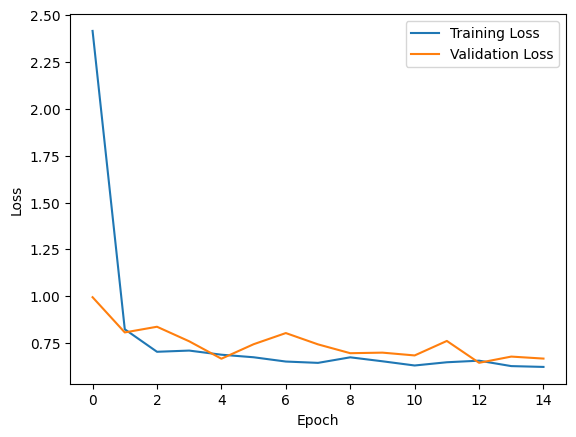

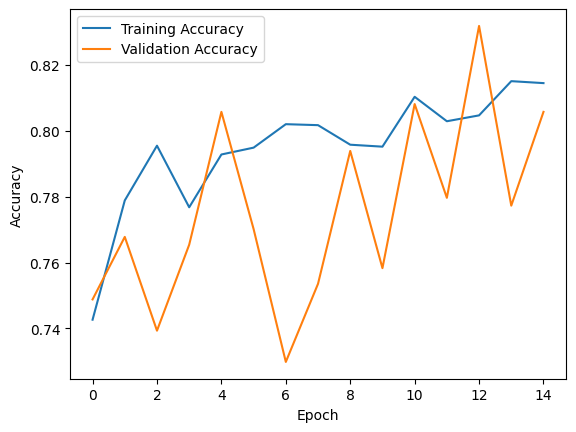

In [17]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Display the Actual and Predicted images

# New section

1/1 [==============================] - 2s 2s/step


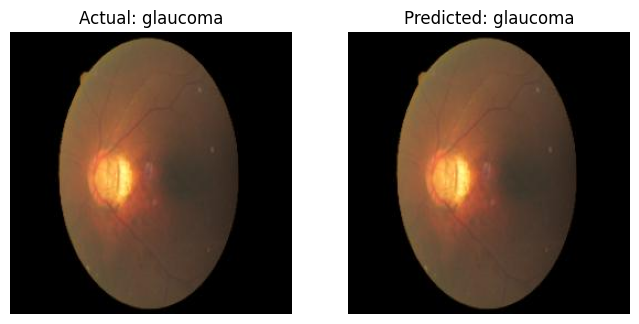

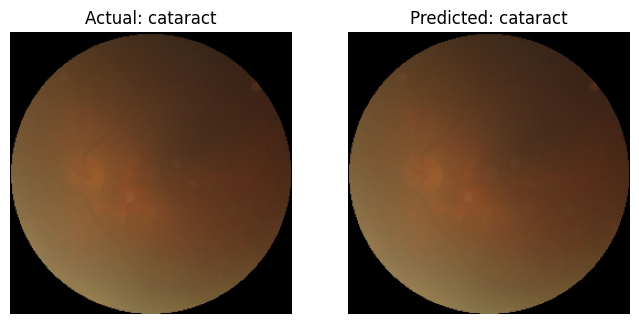

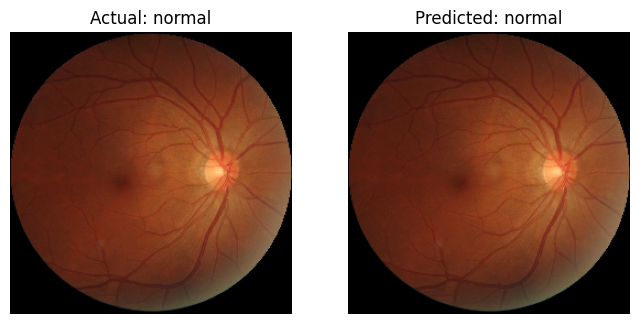

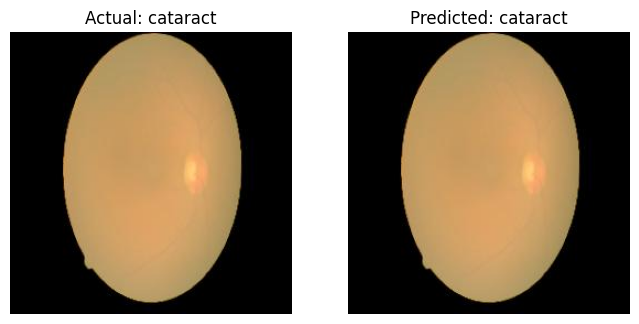

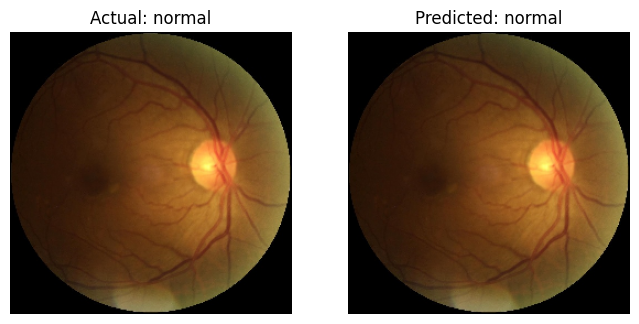

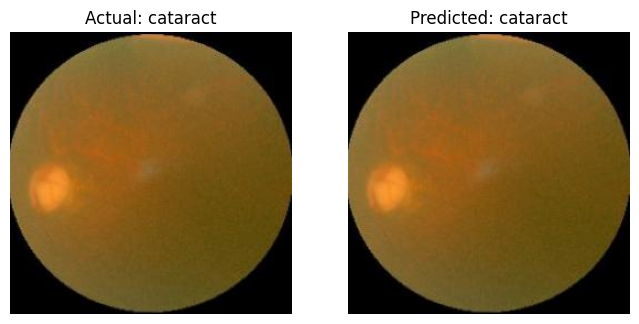

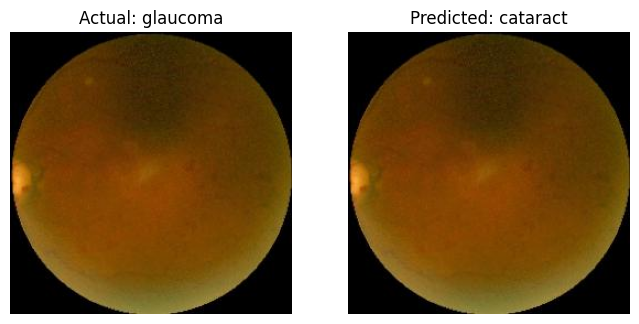

In [18]:
def plot_actual_vs_predicted(model, test_data, num_samples=7):

    # Get a batch of test data
    test_images, test_labels = next(iter(test_data))

    predictions = model.predict(test_images)

    class_labels = list(train_augmented.class_indices.keys())

    sample_indices = np.random.choice(range(len(test_images)), num_samples, replace=False)
      # Plot the images with actual and predicted labels
    for i in sample_indices:
        actual_label = class_labels[np.argmax(test_labels[i])]
        predicted_label = class_labels[np.argmax(predictions[i])]
        plt.figure(figsize=(8, 4))
        # Actual Image
        plt.subplot(1, 2, 1)
        plt.imshow(test_images[i].astype(np.uint8))
        plt.title(f'Actual: {actual_label}')
        plt.axis('off')
        # Predicted Image
        plt.subplot(1, 2, 2)
        plt.imshow(test_images[i].astype(np.uint8))
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()
plot_actual_vs_predicted(model, test_augmented)

In [19]:

model.save('eye.h5')

In [20]:
class_labels = list(train_augmented.class_indices.keys())

In [21]:
class_labels

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [22]:
len(test_augmented)

27

In [23]:
# prompt: find index of 1 in array

import numpy as np
arr = np.array([0, 1, 0, 1, 0])
index_of_ones = np.where(arr == 1)[0]
print(index_of_ones)


[1 3]


In [24]:

test_images, test_labels = next(iter(test_augmented))
predictions = model.predict(test_images)
i=0
for p in predictions:
  print(test_labels[i], class_labels[np.argmax(p)])
  i+=1



1/1 [==============================] - 0s 36ms/step
[0. 1. 0. 0.] diabetic_retinopathy
[0. 0. 0. 1.] normal
[0. 1. 0. 0.] diabetic_retinopathy
[0. 0. 1. 0.] glaucoma
[0. 0. 0. 1.] diabetic_retinopathy
[0. 1. 0. 0.] diabetic_retinopathy
[0. 1. 0. 0.] diabetic_retinopathy
[0. 0. 0. 1.] normal
[0. 0. 0. 1.] diabetic_retinopathy
[0. 1. 0. 0.] diabetic_retinopathy
[0. 1. 0. 0.] diabetic_retinopathy
[0. 0. 0. 1.] normal
[0. 0. 1. 0.] normal
[0. 1. 0. 0.] diabetic_retinopathy
[0. 0. 1. 0.] glaucoma
[0. 1. 0. 0.] diabetic_retinopathy


In [25]:
class_labels[np.argmax(predictions[0])]


'diabetic_retinopathy'

In [26]:
pip install gradio

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.4 MB/s eta 0:00:00
   ━━━━━

In [29]:
import numpy as np
import tensorflow as tf
import gradio as gr

# Load the trained model
model = tf.keras.models.load_model('/content/eye.h5')

# Assuming you have a way to get class labels from your model or training data
# Replace 'train_augmented.class_indices.keys()' with actual class labels if needed
class_labels = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

# Define a function to predict the eye disease
def predict_eye_disease(image):
    # Preprocess the image
    image = np.array(image)  # Convert to numpy array
    image = tf.image.resize(image, (256, 256))  # Resize image to (256, 256)
    image = image / 255.0  # Normalize image

    # Add batch dimension
    image = np.expand_dims(image, axis=0)

    # Predict the eye disease
    prediction = model.predict(image)

    # Get the class label of the prediction
    predicted_label = class_labels[np.argmax(prediction[0])]

    # Return the predicted label
    return predicted_label

# Create a Gradio interface
image_input = gr.Image(type="numpy")  # Set type to numpy to handle the image correctly
label_output = gr.Label(num_top_classes=4)  # Adjust the number of top classes as needed

interface = gr.Interface(
    fn=predict_eye_disease,
    inputs=image_input,
    outputs=label_output,
    examples=[
        '/kaggle/input/eye-diseases-classification/dataset/cataract/0_left.jpg',
        '/kaggle/input/eye-diseases-classification/dataset/diabetic_retinopathy/10003_left.jpeg',
        '/kaggle/input/eye-diseases-classification/dataset/glaucoma/1020_left.jpg',
        '/kaggle/input/eye-diseases-classification/dataset/normal/1034_left.jpg'
    ]
)

# Launch the interface
interface.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://a9b1b6cec4bd0cc527.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 276, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1923, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1508, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 8

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a9b1b6cec4bd0cc527.gradio.live
